In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from prophet import Prophet
from statistics import mean
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
from statsmodels.tools.sm_exceptions import ValueWarning
warnings.filterwarnings('ignore', category=ValueWarning)
warnings.filterwarnings('ignore', category=ConvergenceWarning)
warnings.filterwarnings('ignore')

import logging

logging.getLogger("prophet").setLevel(logging.WARNING)
logging.getLogger("cmdstanpy").disabled = True

def stationary_test(series):
    result = adfuller(series)
    return (result[0], result[1])

data = pd.read_csv('variable_selected_county_dataset.csv').iloc[:, 1:]

In [49]:
#TARRANT

In [50]:
tarrant = data[data['entity'] == 'Texas-Tarrant'].loc[:, ['date', 'incremental_cases']]
tarrant['incremental_cases'] = tarrant['incremental_cases'].astype('int')
tarrant['date'] = pd.to_datetime(tarrant['date'], format="%Y-%m-%d")

# use 85%-15% for train-test split
train = tarrant.iloc[:230, :].rename(columns = {'date':'ds', 'incremental_cases':'y'})
test = tarrant.iloc[230:, :]

print(stationary_test(train.y))

(-0.7851430797441187, 0.8234472689051321)


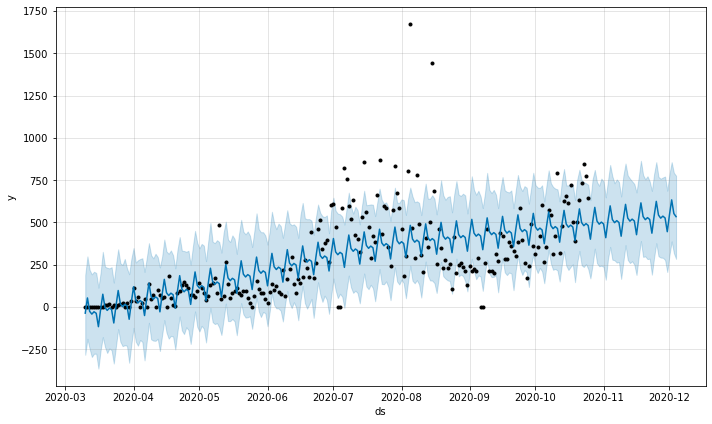

In [51]:
model = Prophet().fit(train)
pred = model.predict(model.make_future_dataframe(periods=40))
model.plot(pred);

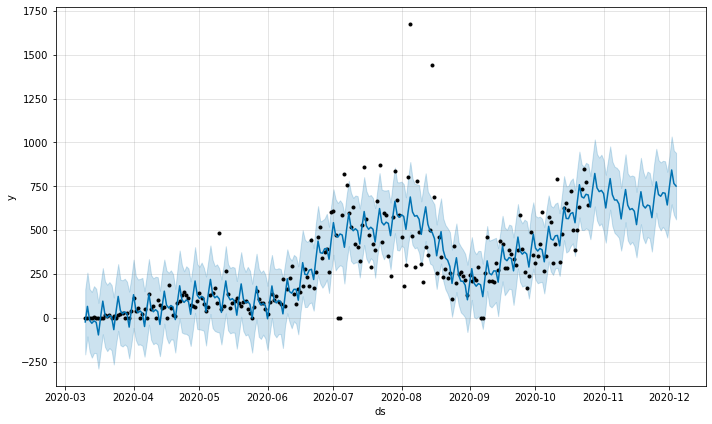

In [52]:
model = Prophet(yearly_seasonality=True, weekly_seasonality=True).fit(train)
pred = model.predict(model.make_future_dataframe(periods=40))
model.plot(pred);

<AxesSubplot:xlabel='date'>

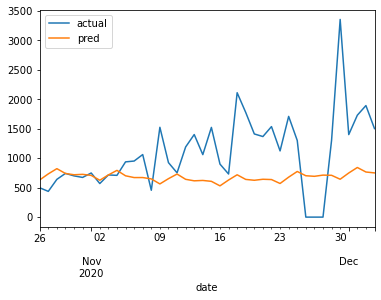

In [53]:


prediction = pd.DataFrame({'actual':test.incremental_cases.reset_index(drop = True),
              'pred':pred.tail(40).yhat.reset_index(drop = True)})
prediction['date'] = test['date'].reset_index(drop = True)
prediction.plot(x = 'date', y = ['actual', 'pred'])

In [54]:
mape = mean_absolute_error(pred.tail(40).yhat, test.incremental_cases)/mean(test.incremental_cases) 
print(mape)

0.5133013036867213


In [55]:
tscv = TimeSeriesSplit(n_splits = 5)

train = train.reset_index().drop(columns = 'index')

param_grid = {
    'changepoint_prior_scale': [0.001, 0.01, 0.1],
    'seasonality_prior_scale': [0.01, 0.1, 1.0],
    'holidays_prior_scale': [0.01, 0.1, 1.0],
    'seasonality_mode': ['additive', 'multiplicative']
}

best_score, best_param = float("inf"), None

for param in ParameterGrid(param_grid):
    all_mse = 0
    for train_index, val_index in tscv.split(train):
      train_data, val_data = train.loc[train_index, :], train.loc[val_index, :]
      model = Prophet(**param).fit(train_data)
      pred = model.predict(val_data)
      mse = mean_squared_error(val_data.y, pred.yhat)
      all_mse = all_mse + mse
    print(f'params: {param} with mean MSE: {all_mse / 3}')
    if all_mse / 3 < best_score:
      best_score, best_param = all_mse / 3, param

print(f'Best Prophet parameters: {best_param} with mean MSE: {best_score}')

Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01} with mean MSE: 113220.74458232937


Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1} with mean MSE: 118474.09573991806


Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0} with mean MSE: 117894.32268581954


Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01} with mean MSE: 115649.82691416785


Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1} with mean MSE: 121978.15328284314


Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0} with mean MSE: 128429.27263334423


Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01} with mean MSE: 113220.74458232937


Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1} with mean MSE: 118474.09573991806


Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0} with mean MSE: 117894.32268581954


Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01} with mean MSE: 115649.82691416785


Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1} with mean MSE: 121978.15328284314


Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0} with mean MSE: 128429.27263334423


Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01} with mean MSE: 113220.74458232937


Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1} with mean MSE: 118474.09573991806


Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0} with mean MSE: 117894.32268581954


Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01} with mean MSE: 115649.82691416785


Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1} with mean MSE: 121978.15328284314


Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0} with mean MSE: 128429.27263334423


Optimization terminated abnormally. Falling back to Newton.


params: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01} with mean MSE: 109264.8362661983


Optimization terminated abnormally. Falling back to Newton.


params: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1} with mean MSE: 112151.86118847964


Optimization terminated abnormally. Falling back to Newton.


params: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0} with mean MSE: 113881.04025479755


Optimization terminated abnormally. Falling back to Newton.


params: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01} with mean MSE: 113197.19369363888


Optimization terminated abnormally. Falling back to Newton.


params: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1} with mean MSE: 125401.02307989233


Optimization terminated abnormally. Falling back to Newton.


params: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0} with mean MSE: 135101.15279543758


Optimization terminated abnormally. Falling back to Newton.


params: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01} with mean MSE: 109264.8362661983


Optimization terminated abnormally. Falling back to Newton.


params: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1} with mean MSE: 112151.86118847964


Optimization terminated abnormally. Falling back to Newton.


params: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0} with mean MSE: 113881.04025479755


Optimization terminated abnormally. Falling back to Newton.


params: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01} with mean MSE: 113197.19369363888


Optimization terminated abnormally. Falling back to Newton.


params: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1} with mean MSE: 125401.02307989233


Optimization terminated abnormally. Falling back to Newton.


params: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0} with mean MSE: 135101.15279543758


Optimization terminated abnormally. Falling back to Newton.


params: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01} with mean MSE: 109264.8362661983


Optimization terminated abnormally. Falling back to Newton.


params: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1} with mean MSE: 112151.86118847964


Optimization terminated abnormally. Falling back to Newton.


params: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0} with mean MSE: 113881.04025479755


Optimization terminated abnormally. Falling back to Newton.


params: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01} with mean MSE: 113197.19369363888


Optimization terminated abnormally. Falling back to Newton.


params: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1} with mean MSE: 125401.02307989233


Optimization terminated abnormally. Falling back to Newton.


params: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0} with mean MSE: 135101.15279543758
params: {'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01} with mean MSE: 196012.75614796393
params: {'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1} with mean MSE: 201693.43617098118
params: {'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0} with mean MSE: 197225.69444196104
params: {'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01} with mean MSE: 193216.4390954169
params: {'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1} w

0.5225091493957751


<AxesSubplot:xlabel='date'>

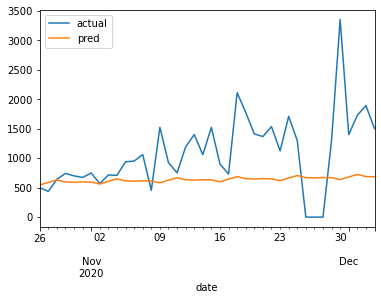

In [56]:
model = Prophet(**best_param).fit(train)
pred = model.predict(model.make_future_dataframe(periods=40))
mape = mean_absolute_error(pred.tail(40).yhat, test.incremental_cases)/mean(test.incremental_cases) 
print(mape)

prediction = pd.DataFrame({'actual':test.incremental_cases.reset_index(drop = True),
              'pred':pred.tail(40).yhat.reset_index(drop = True)})
prediction['date'] = test['date'].reset_index(drop = True)
prediction.plot(x = 'date', y = ['actual', 'pred'])

In [57]:
param_grid = {
    'changepoint_prior_scale': [0.005, 0.01, .015, 0.02, 0.03],
    'seasonality_prior_scale': [0.005, 0.01, .015, 0.02, 0.03],
    'holidays_prior_scale': [0.005,.007, 0.01, 0.015, 0.02],
    'seasonality_mode': ['additive', 'multiplicative']
}

best_score, best_param = float("inf"), None

for param in ParameterGrid(param_grid):
    all_mse = 0
    for train_index, val_index in tscv.split(train):
      train_data, val_data = train.loc[train_index, :], train.loc[val_index, :]
      model = Prophet(**param).fit(train_data)
      pred = model.predict(val_data)
      mse = mean_squared_error(val_data.y, pred.yhat)
      all_mse = all_mse + mse
    print(f'params: {param} with mean MSE: {all_mse / 3}')
    if all_mse / 3 < best_score:
      best_score, best_param = all_mse / 3, param

print(f'Best Prophet parameters: {best_param} with mean MSE: {best_score}')

Optimization terminated abnormally. Falling back to Newton.


params: {'changepoint_prior_scale': 0.005, 'holidays_prior_scale': 0.005, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.005} with mean MSE: 105554.13922615907


Optimization terminated abnormally. Falling back to Newton.


params: {'changepoint_prior_scale': 0.005, 'holidays_prior_scale': 0.005, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01} with mean MSE: 100285.00585335131


Optimization terminated abnormally. Falling back to Newton.


params: {'changepoint_prior_scale': 0.005, 'holidays_prior_scale': 0.005, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.015} with mean MSE: 109124.49767439876


Optimization terminated abnormally. Falling back to Newton.


params: {'changepoint_prior_scale': 0.005, 'holidays_prior_scale': 0.005, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.02} with mean MSE: 117780.6847726797


Optimization terminated abnormally. Falling back to Newton.


params: {'changepoint_prior_scale': 0.005, 'holidays_prior_scale': 0.005, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.03} with mean MSE: 116924.04194554302


Optimization terminated abnormally. Falling back to Newton.


params: {'changepoint_prior_scale': 0.005, 'holidays_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.005} with mean MSE: 117772.82518724167


Optimization terminated abnormally. Falling back to Newton.


params: {'changepoint_prior_scale': 0.005, 'holidays_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01} with mean MSE: 116352.56767619766


Optimization terminated abnormally. Falling back to Newton.


params: {'changepoint_prior_scale': 0.005, 'holidays_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.015} with mean MSE: 120898.02576502839


Optimization terminated abnormally. Falling back to Newton.


params: {'changepoint_prior_scale': 0.005, 'holidays_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.02} with mean MSE: 105213.27811862122


Optimization terminated abnormally. Falling back to Newton.


params: {'changepoint_prior_scale': 0.005, 'holidays_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.03} with mean MSE: 114729.18483366951


Optimization terminated abnormally. Falling back to Newton.


params: {'changepoint_prior_scale': 0.005, 'holidays_prior_scale': 0.007, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.005} with mean MSE: 105554.13922615907


Optimization terminated abnormally. Falling back to Newton.


params: {'changepoint_prior_scale': 0.005, 'holidays_prior_scale': 0.007, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01} with mean MSE: 100285.00585335131


Optimization terminated abnormally. Falling back to Newton.


params: {'changepoint_prior_scale': 0.005, 'holidays_prior_scale': 0.007, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.015} with mean MSE: 109124.49767439876


Optimization terminated abnormally. Falling back to Newton.


params: {'changepoint_prior_scale': 0.005, 'holidays_prior_scale': 0.007, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.02} with mean MSE: 117780.6847726797


Optimization terminated abnormally. Falling back to Newton.


params: {'changepoint_prior_scale': 0.005, 'holidays_prior_scale': 0.007, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.03} with mean MSE: 116924.04194554302


Optimization terminated abnormally. Falling back to Newton.


params: {'changepoint_prior_scale': 0.005, 'holidays_prior_scale': 0.007, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.005} with mean MSE: 117772.82518724167


Optimization terminated abnormally. Falling back to Newton.


params: {'changepoint_prior_scale': 0.005, 'holidays_prior_scale': 0.007, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01} with mean MSE: 116352.56767619766


Optimization terminated abnormally. Falling back to Newton.


params: {'changepoint_prior_scale': 0.005, 'holidays_prior_scale': 0.007, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.015} with mean MSE: 120898.02576502839


Optimization terminated abnormally. Falling back to Newton.


params: {'changepoint_prior_scale': 0.005, 'holidays_prior_scale': 0.007, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.02} with mean MSE: 105213.27811862122


Optimization terminated abnormally. Falling back to Newton.


params: {'changepoint_prior_scale': 0.005, 'holidays_prior_scale': 0.007, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.03} with mean MSE: 114729.18483366951


Optimization terminated abnormally. Falling back to Newton.


params: {'changepoint_prior_scale': 0.005, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.005} with mean MSE: 105554.13922615907


Optimization terminated abnormally. Falling back to Newton.


params: {'changepoint_prior_scale': 0.005, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01} with mean MSE: 100285.00585335131


Optimization terminated abnormally. Falling back to Newton.


params: {'changepoint_prior_scale': 0.005, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.015} with mean MSE: 109124.49767439876


Optimization terminated abnormally. Falling back to Newton.


params: {'changepoint_prior_scale': 0.005, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.02} with mean MSE: 117780.6847726797


Optimization terminated abnormally. Falling back to Newton.


params: {'changepoint_prior_scale': 0.005, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.03} with mean MSE: 116924.04194554302


Optimization terminated abnormally. Falling back to Newton.


params: {'changepoint_prior_scale': 0.005, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.005} with mean MSE: 117772.82518724167


Optimization terminated abnormally. Falling back to Newton.


params: {'changepoint_prior_scale': 0.005, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01} with mean MSE: 116352.56767619766


Optimization terminated abnormally. Falling back to Newton.


params: {'changepoint_prior_scale': 0.005, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.015} with mean MSE: 120898.02576502839


Optimization terminated abnormally. Falling back to Newton.


params: {'changepoint_prior_scale': 0.005, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.02} with mean MSE: 105213.27811862122


Optimization terminated abnormally. Falling back to Newton.


params: {'changepoint_prior_scale': 0.005, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.03} with mean MSE: 114729.18483366951


Optimization terminated abnormally. Falling back to Newton.


params: {'changepoint_prior_scale': 0.005, 'holidays_prior_scale': 0.015, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.005} with mean MSE: 105554.13922615907


Optimization terminated abnormally. Falling back to Newton.


params: {'changepoint_prior_scale': 0.005, 'holidays_prior_scale': 0.015, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01} with mean MSE: 100285.00585335131


Optimization terminated abnormally. Falling back to Newton.


params: {'changepoint_prior_scale': 0.005, 'holidays_prior_scale': 0.015, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.015} with mean MSE: 109124.49767439876


Optimization terminated abnormally. Falling back to Newton.


params: {'changepoint_prior_scale': 0.005, 'holidays_prior_scale': 0.015, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.02} with mean MSE: 117780.6847726797


Optimization terminated abnormally. Falling back to Newton.


params: {'changepoint_prior_scale': 0.005, 'holidays_prior_scale': 0.015, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.03} with mean MSE: 116924.04194554302


Optimization terminated abnormally. Falling back to Newton.


params: {'changepoint_prior_scale': 0.005, 'holidays_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.005} with mean MSE: 117772.82518724167


Optimization terminated abnormally. Falling back to Newton.


params: {'changepoint_prior_scale': 0.005, 'holidays_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01} with mean MSE: 116352.56767619766


Optimization terminated abnormally. Falling back to Newton.


params: {'changepoint_prior_scale': 0.005, 'holidays_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.015} with mean MSE: 120898.02576502839


Optimization terminated abnormally. Falling back to Newton.


params: {'changepoint_prior_scale': 0.005, 'holidays_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.02} with mean MSE: 105213.27811862122


Optimization terminated abnormally. Falling back to Newton.


params: {'changepoint_prior_scale': 0.005, 'holidays_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.03} with mean MSE: 114729.18483366951


Optimization terminated abnormally. Falling back to Newton.


params: {'changepoint_prior_scale': 0.005, 'holidays_prior_scale': 0.02, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.005} with mean MSE: 105554.13922615907


Optimization terminated abnormally. Falling back to Newton.


params: {'changepoint_prior_scale': 0.005, 'holidays_prior_scale': 0.02, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01} with mean MSE: 100285.00585335131


Optimization terminated abnormally. Falling back to Newton.


params: {'changepoint_prior_scale': 0.005, 'holidays_prior_scale': 0.02, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.015} with mean MSE: 109124.49767439876


Optimization terminated abnormally. Falling back to Newton.


params: {'changepoint_prior_scale': 0.005, 'holidays_prior_scale': 0.02, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.02} with mean MSE: 117780.6847726797


Optimization terminated abnormally. Falling back to Newton.


params: {'changepoint_prior_scale': 0.005, 'holidays_prior_scale': 0.02, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.03} with mean MSE: 116924.04194554302


Optimization terminated abnormally. Falling back to Newton.


params: {'changepoint_prior_scale': 0.005, 'holidays_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.005} with mean MSE: 117772.82518724167


Optimization terminated abnormally. Falling back to Newton.


params: {'changepoint_prior_scale': 0.005, 'holidays_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01} with mean MSE: 116352.56767619766


Optimization terminated abnormally. Falling back to Newton.


params: {'changepoint_prior_scale': 0.005, 'holidays_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.015} with mean MSE: 120898.02576502839


Optimization terminated abnormally. Falling back to Newton.


params: {'changepoint_prior_scale': 0.005, 'holidays_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.02} with mean MSE: 105213.27811862122


Optimization terminated abnormally. Falling back to Newton.


params: {'changepoint_prior_scale': 0.005, 'holidays_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.03} with mean MSE: 114729.18483366951


Optimization terminated abnormally. Falling back to Newton.


params: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.005, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.005} with mean MSE: 115099.08925271423


Optimization terminated abnormally. Falling back to Newton.


params: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.005, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01} with mean MSE: 109264.8362661983


Optimization terminated abnormally. Falling back to Newton.


params: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.005, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.015} with mean MSE: 114430.4387213437


Optimization terminated abnormally. Falling back to Newton.


params: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.005, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.02} with mean MSE: 111931.5431379971


Optimization terminated abnormally. Falling back to Newton.


params: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.005, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.03} with mean MSE: 119333.42027553717


Optimization terminated abnormally. Falling back to Newton.


params: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.005} with mean MSE: 113818.51278643603


Optimization terminated abnormally. Falling back to Newton.


params: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01} with mean MSE: 113197.19369363888


Optimization terminated abnormally. Falling back to Newton.


params: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.015} with mean MSE: 110410.90089483724


Optimization terminated abnormally. Falling back to Newton.


params: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.02} with mean MSE: 113298.2759286024


Optimization terminated abnormally. Falling back to Newton.


params: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.03} with mean MSE: 114700.41784944168


Optimization terminated abnormally. Falling back to Newton.


params: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.007, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.005} with mean MSE: 115099.08925271423


Optimization terminated abnormally. Falling back to Newton.


params: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.007, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01} with mean MSE: 109264.8362661983


Optimization terminated abnormally. Falling back to Newton.


params: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.007, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.015} with mean MSE: 114430.4387213437


Optimization terminated abnormally. Falling back to Newton.


params: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.007, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.02} with mean MSE: 111931.5431379971


Optimization terminated abnormally. Falling back to Newton.


params: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.007, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.03} with mean MSE: 119333.42027553717


Optimization terminated abnormally. Falling back to Newton.


params: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.007, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.005} with mean MSE: 113818.51278643603


Optimization terminated abnormally. Falling back to Newton.


params: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.007, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01} with mean MSE: 113197.19369363888


Optimization terminated abnormally. Falling back to Newton.


params: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.007, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.015} with mean MSE: 110410.90089483724


Optimization terminated abnormally. Falling back to Newton.


params: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.007, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.02} with mean MSE: 113298.2759286024


Optimization terminated abnormally. Falling back to Newton.


params: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.007, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.03} with mean MSE: 114700.41784944168


Optimization terminated abnormally. Falling back to Newton.


params: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.005} with mean MSE: 115099.08925271423


Optimization terminated abnormally. Falling back to Newton.


params: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01} with mean MSE: 109264.8362661983


Optimization terminated abnormally. Falling back to Newton.


params: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.015} with mean MSE: 114430.4387213437


Optimization terminated abnormally. Falling back to Newton.


params: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.02} with mean MSE: 111931.5431379971


Optimization terminated abnormally. Falling back to Newton.


params: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.03} with mean MSE: 119333.42027553717


Optimization terminated abnormally. Falling back to Newton.


params: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.005} with mean MSE: 113818.51278643603


Optimization terminated abnormally. Falling back to Newton.


params: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01} with mean MSE: 113197.19369363888


Optimization terminated abnormally. Falling back to Newton.


params: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.015} with mean MSE: 110410.90089483724


Optimization terminated abnormally. Falling back to Newton.


params: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.02} with mean MSE: 113298.2759286024


Optimization terminated abnormally. Falling back to Newton.


params: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.03} with mean MSE: 114700.41784944168


Optimization terminated abnormally. Falling back to Newton.


params: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.015, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.005} with mean MSE: 115099.08925271423


Optimization terminated abnormally. Falling back to Newton.


params: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.015, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01} with mean MSE: 109264.8362661983


Optimization terminated abnormally. Falling back to Newton.


params: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.015, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.015} with mean MSE: 114430.4387213437


Optimization terminated abnormally. Falling back to Newton.


params: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.015, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.02} with mean MSE: 111931.5431379971


Optimization terminated abnormally. Falling back to Newton.


params: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.015, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.03} with mean MSE: 119333.42027553717


Optimization terminated abnormally. Falling back to Newton.


params: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.005} with mean MSE: 113818.51278643603


Optimization terminated abnormally. Falling back to Newton.


params: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01} with mean MSE: 113197.19369363888


Optimization terminated abnormally. Falling back to Newton.


params: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.015} with mean MSE: 110410.90089483724


Optimization terminated abnormally. Falling back to Newton.


params: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.02} with mean MSE: 113298.2759286024


Optimization terminated abnormally. Falling back to Newton.


params: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.03} with mean MSE: 114700.41784944168


Optimization terminated abnormally. Falling back to Newton.


params: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.02, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.005} with mean MSE: 115099.08925271423


Optimization terminated abnormally. Falling back to Newton.


params: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.02, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01} with mean MSE: 109264.8362661983


Optimization terminated abnormally. Falling back to Newton.


params: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.02, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.015} with mean MSE: 114430.4387213437


Optimization terminated abnormally. Falling back to Newton.


params: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.02, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.02} with mean MSE: 111931.5431379971


Optimization terminated abnormally. Falling back to Newton.


params: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.02, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.03} with mean MSE: 119333.42027553717


Optimization terminated abnormally. Falling back to Newton.


params: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.005} with mean MSE: 113818.51278643603


Optimization terminated abnormally. Falling back to Newton.


params: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01} with mean MSE: 113197.19369363888


Optimization terminated abnormally. Falling back to Newton.


params: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.015} with mean MSE: 110410.90089483724


Optimization terminated abnormally. Falling back to Newton.


params: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.02} with mean MSE: 113298.2759286024


Optimization terminated abnormally. Falling back to Newton.


params: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.03} with mean MSE: 114700.41784944168
params: {'changepoint_prior_scale': 0.015, 'holidays_prior_scale': 0.005, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.005} with mean MSE: 119655.33401461698
params: {'changepoint_prior_scale': 0.015, 'holidays_prior_scale': 0.005, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01} with mean MSE: 120585.47086518595
params: {'changepoint_prior_scale': 0.015, 'holidays_prior_scale': 0.005, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.015} with mean MSE: 120267.85227140498
params: {'changepoint_prior_scale': 0.015, 'holidays_prior_scale': 0.005, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.02} with mean MSE: 117954.84069217693
params: {'changepoint_prior_scale': 0.015, 'holidays_prior_scale': 0.005, 'seasonality_mode': 'additive', 'seasonality_prior_scal

params: {'changepoint_prior_scale': 0.015, 'holidays_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01} with mean MSE: 116021.12179100917
params: {'changepoint_prior_scale': 0.015, 'holidays_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.015} with mean MSE: 115920.04568655991
params: {'changepoint_prior_scale': 0.015, 'holidays_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.02} with mean MSE: 115996.40903218607
params: {'changepoint_prior_scale': 0.015, 'holidays_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.03} with mean MSE: 124995.26828462014
params: {'changepoint_prior_scale': 0.02, 'holidays_prior_scale': 0.005, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.005} with mean MSE: 123335.66469366285
params: {'changepoint_prior_scale': 0.02, 'holidays_prior_scale': 0.005, 'seasonality_mode': 'additive', 'seasonal

params: {'changepoint_prior_scale': 0.02, 'holidays_prior_scale': 0.02, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.02} with mean MSE: 126666.25787456456
params: {'changepoint_prior_scale': 0.02, 'holidays_prior_scale': 0.02, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.03} with mean MSE: 125515.28744585603
params: {'changepoint_prior_scale': 0.02, 'holidays_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.005} with mean MSE: 120945.41742885881
params: {'changepoint_prior_scale': 0.02, 'holidays_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01} with mean MSE: 121544.81787706626
params: {'changepoint_prior_scale': 0.02, 'holidays_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.015} with mean MSE: 122529.4402639162
params: {'changepoint_prior_scale': 0.02, 'holidays_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'seasonality_pri

params: {'changepoint_prior_scale': 0.03, 'holidays_prior_scale': 0.02, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.005} with mean MSE: 134707.08262920307
params: {'changepoint_prior_scale': 0.03, 'holidays_prior_scale': 0.02, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01} with mean MSE: 138336.8249696275
params: {'changepoint_prior_scale': 0.03, 'holidays_prior_scale': 0.02, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.015} with mean MSE: 138705.90565930223
params: {'changepoint_prior_scale': 0.03, 'holidays_prior_scale': 0.02, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.02} with mean MSE: 137176.31185827844
params: {'changepoint_prior_scale': 0.03, 'holidays_prior_scale': 0.02, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.03} with mean MSE: 137058.02202877778
params: {'changepoint_prior_scale': 0.03, 'holidays_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.005} 

0.5222493900636659


<AxesSubplot:xlabel='date'>

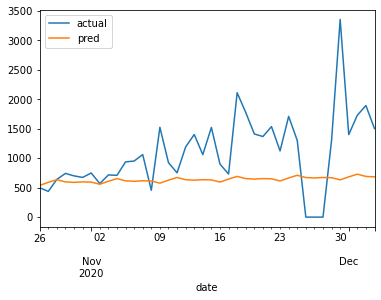

In [58]:
model = Prophet(**best_param).fit(train)
pred = model.predict(model.make_future_dataframe(periods=40))
mape = mean_absolute_error(pred.tail(40).yhat, test.incremental_cases)/mean(test.incremental_cases) 
print(mape)

prediction = pd.DataFrame({'actual':test.incremental_cases.reset_index(drop = True),
              'pred':pred.tail(40).yhat.reset_index(drop = True)})
prediction['date'] = test['date'].reset_index(drop = True)
prediction.plot(x = 'date', y = ['actual', 'pred'])

In [59]:
#Harris

In [60]:
harris = data[data['entity'] == 'Texas-Harris'].loc[:, ['date', 'incremental_cases']]
harris['incremental_cases'] = harris['incremental_cases'].astype('int')
harris['date'] = pd.to_datetime(harris['date'], format="%Y-%m-%d")

# use 85%-15% for train-test split
train = harris.iloc[:230, :].rename(columns = {'date':'ds', 'incremental_cases':'y'})
test = harris.iloc[230:, :]

print(stationary_test(train.y))

(-2.2416106051506035, 0.19149116285834866)


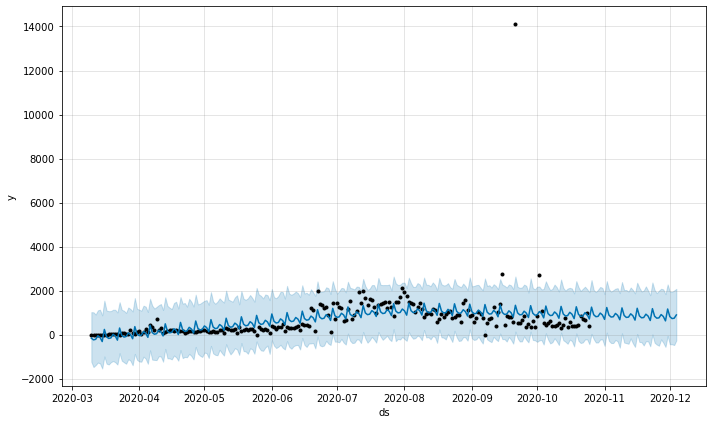

In [61]:
model = Prophet().fit(train)
pred = model.predict(model.make_future_dataframe(periods=40))
model.plot(pred);

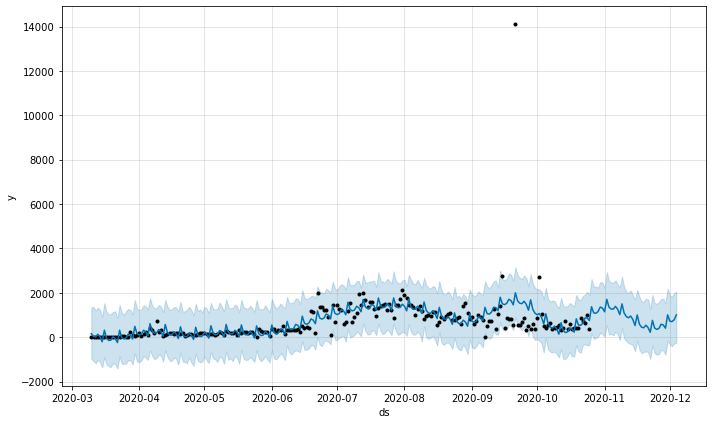

In [62]:
model = Prophet(yearly_seasonality=True, weekly_seasonality=True).fit(train)
pred = model.predict(model.make_future_dataframe(periods=40))
model.plot(pred);

0.6945440922608748


<AxesSubplot:xlabel='date'>

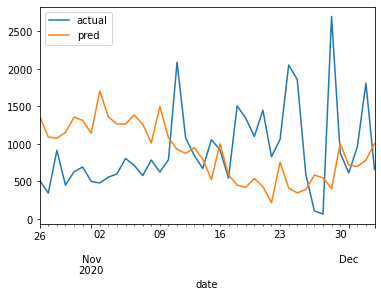

In [63]:
mape = mean_absolute_error(pred.tail(40).yhat, test.incremental_cases)/mean(test.incremental_cases) 
print(mape)

prediction = pd.DataFrame({'actual':test.incremental_cases.reset_index(drop = True),
              'pred':pred.tail(40).yhat.reset_index(drop = True)})
prediction['date'] = test['date'].reset_index(drop = True)
prediction.plot(x = 'date', y = ['actual', 'pred'])

In [64]:
tscv = TimeSeriesSplit(n_splits = 5)

train = train.reset_index().drop(columns = 'index')

param_grid = {
    'changepoint_prior_scale': [0.001, 0.01, 0.1],
    'seasonality_prior_scale': [0.01, 0.1, 1.0],
    'holidays_prior_scale': [0.01, 0.1, 1.0],
    'seasonality_mode': ['additive', 'multiplicative']
}

best_score, best_param = float("inf"), None

for param in ParameterGrid(param_grid):
    all_mse = 0
    for train_index, val_index in tscv.split(train):
      train_data, val_data = train.loc[train_index, :], train.loc[val_index, :]
      model = Prophet(**param).fit(train_data)
      pred = model.predict(val_data)
      mse = mean_squared_error(val_data.y, pred.yhat)
      all_mse = all_mse + mse
    print(f'params: {param} with mean MSE: {all_mse / 3}')
    if all_mse / 3 < best_score:
      best_score, best_param = all_mse / 3, param

print(f'Best Prophet parameters: {best_param} with mean MSE: {best_score}')

Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01} with mean MSE: 2186977.301393283


Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1} with mean MSE: 2188795.442032576


Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0} with mean MSE: 2189569.4982936336


Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01} with mean MSE: 2189418.352964953


Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1} with mean MSE: 2203501.8431890723


Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0} with mean MSE: 2224337.0692150826


Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01} with mean MSE: 2186977.301393283


Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1} with mean MSE: 2188795.442032576


Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0} with mean MSE: 2189569.4982936336


Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01} with mean MSE: 2189418.352964953


Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1} with mean MSE: 2203501.8431890723


Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0} with mean MSE: 2224337.0692150826


Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01} with mean MSE: 2186977.301393283


Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1} with mean MSE: 2188795.442032576


Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0} with mean MSE: 2189569.4982936336


Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01} with mean MSE: 2189418.352964953


Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1} with mean MSE: 2203501.8431890723


Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0} with mean MSE: 2224337.0692150826
params: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01} with mean MSE: 2093946.0526220473
params: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1} with mean MSE: 2143856.7483197493
params: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0} with mean MSE: 2126126.613943127
params: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01} with mean MSE: 2122285.3060637806
params: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 

0.6933169090175538


<AxesSubplot:xlabel='date'>

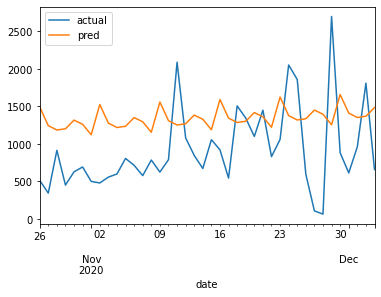

In [65]:
model = Prophet(**best_param).fit(train)
pred = model.predict(model.make_future_dataframe(periods=40))
mape = mean_absolute_error(pred.tail(40).yhat, test.incremental_cases)/mean(test.incremental_cases) 
print(mape)

prediction = pd.DataFrame({'actual':test.incremental_cases.reset_index(drop = True),
              'pred':pred.tail(40).yhat.reset_index(drop = True)})
prediction['date'] = test['date'].reset_index(drop = True)
prediction.plot(x = 'date', y = ['actual', 'pred'])

In [66]:
param_grid = {
    'changepoint_prior_scale': [ .007,.008,.009,0.01,.011],
    'seasonality_prior_scale': [.007,.008,.009,0.01,.011],
    'holidays_prior_scale': [0.005,.007, 0.01, 0.015, 0.02],
    'seasonality_mode': ['additive', 'multiplicative']
}

best_score, best_param = float("inf"), None

for param in ParameterGrid(param_grid):
    all_mse = 0
    for train_index, val_index in tscv.split(train):
      train_data, val_data = train.loc[train_index, :], train.loc[val_index, :]
      model = Prophet(**param).fit(train_data)
      pred = model.predict(val_data)
      mse = mean_squared_error(val_data.y, pred.yhat)
      all_mse = all_mse + mse
    print(f'params: {param} with mean MSE: {all_mse / 3}')
    if all_mse / 3 < best_score:
      best_score, best_param = all_mse / 3, param

print(f'Best Prophet parameters: {best_param} with mean MSE: {best_score}')

Optimization terminated abnormally. Falling back to Newton.


params: {'changepoint_prior_scale': 0.007, 'holidays_prior_scale': 0.005, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.007} with mean MSE: 2074813.0986951645


Optimization terminated abnormally. Falling back to Newton.


params: {'changepoint_prior_scale': 0.007, 'holidays_prior_scale': 0.005, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.008} with mean MSE: 2169431.818092184


Optimization terminated abnormally. Falling back to Newton.


params: {'changepoint_prior_scale': 0.007, 'holidays_prior_scale': 0.005, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.009} with mean MSE: 2147744.856020784


Optimization terminated abnormally. Falling back to Newton.


params: {'changepoint_prior_scale': 0.007, 'holidays_prior_scale': 0.005, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01} with mean MSE: 2126456.6226378246


Optimization terminated abnormally. Falling back to Newton.


params: {'changepoint_prior_scale': 0.007, 'holidays_prior_scale': 0.005, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.011} with mean MSE: 2099384.513162698


Optimization terminated abnormally. Falling back to Newton.


params: {'changepoint_prior_scale': 0.007, 'holidays_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.007} with mean MSE: 2183832.730694592


Optimization terminated abnormally. Falling back to Newton.


params: {'changepoint_prior_scale': 0.007, 'holidays_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.008} with mean MSE: 2119894.223951282


Optimization terminated abnormally. Falling back to Newton.


params: {'changepoint_prior_scale': 0.007, 'holidays_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.009} with mean MSE: 2121915.1257444923


Optimization terminated abnormally. Falling back to Newton.


params: {'changepoint_prior_scale': 0.007, 'holidays_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01} with mean MSE: 2115679.459266355


Optimization terminated abnormally. Falling back to Newton.


params: {'changepoint_prior_scale': 0.007, 'holidays_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.011} with mean MSE: 2159217.3099590843


Optimization terminated abnormally. Falling back to Newton.


params: {'changepoint_prior_scale': 0.007, 'holidays_prior_scale': 0.007, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.007} with mean MSE: 2074813.0986951645


Optimization terminated abnormally. Falling back to Newton.


params: {'changepoint_prior_scale': 0.007, 'holidays_prior_scale': 0.007, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.008} with mean MSE: 2169431.818092184


Optimization terminated abnormally. Falling back to Newton.


params: {'changepoint_prior_scale': 0.007, 'holidays_prior_scale': 0.007, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.009} with mean MSE: 2147744.856020784


Optimization terminated abnormally. Falling back to Newton.


params: {'changepoint_prior_scale': 0.007, 'holidays_prior_scale': 0.007, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01} with mean MSE: 2126456.6226378246


Optimization terminated abnormally. Falling back to Newton.


params: {'changepoint_prior_scale': 0.007, 'holidays_prior_scale': 0.007, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.011} with mean MSE: 2099384.513162698


Optimization terminated abnormally. Falling back to Newton.


params: {'changepoint_prior_scale': 0.007, 'holidays_prior_scale': 0.007, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.007} with mean MSE: 2183832.730694592


Optimization terminated abnormally. Falling back to Newton.


params: {'changepoint_prior_scale': 0.007, 'holidays_prior_scale': 0.007, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.008} with mean MSE: 2119894.223951282


Optimization terminated abnormally. Falling back to Newton.


params: {'changepoint_prior_scale': 0.007, 'holidays_prior_scale': 0.007, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.009} with mean MSE: 2121915.1257444923


Optimization terminated abnormally. Falling back to Newton.


params: {'changepoint_prior_scale': 0.007, 'holidays_prior_scale': 0.007, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01} with mean MSE: 2115679.459266355


Optimization terminated abnormally. Falling back to Newton.


params: {'changepoint_prior_scale': 0.007, 'holidays_prior_scale': 0.007, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.011} with mean MSE: 2159217.3099590843


Optimization terminated abnormally. Falling back to Newton.


params: {'changepoint_prior_scale': 0.007, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.007} with mean MSE: 2074813.0986951645


Optimization terminated abnormally. Falling back to Newton.


params: {'changepoint_prior_scale': 0.007, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.008} with mean MSE: 2169431.818092184


Optimization terminated abnormally. Falling back to Newton.


params: {'changepoint_prior_scale': 0.007, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.009} with mean MSE: 2147744.856020784


Optimization terminated abnormally. Falling back to Newton.


params: {'changepoint_prior_scale': 0.007, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01} with mean MSE: 2126456.6226378246


Optimization terminated abnormally. Falling back to Newton.


params: {'changepoint_prior_scale': 0.007, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.011} with mean MSE: 2099384.513162698


Optimization terminated abnormally. Falling back to Newton.


params: {'changepoint_prior_scale': 0.007, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.007} with mean MSE: 2183832.730694592


Optimization terminated abnormally. Falling back to Newton.


params: {'changepoint_prior_scale': 0.007, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.008} with mean MSE: 2119894.223951282


Optimization terminated abnormally. Falling back to Newton.


params: {'changepoint_prior_scale': 0.007, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.009} with mean MSE: 2121915.1257444923


Optimization terminated abnormally. Falling back to Newton.


params: {'changepoint_prior_scale': 0.007, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01} with mean MSE: 2115679.459266355


Optimization terminated abnormally. Falling back to Newton.


params: {'changepoint_prior_scale': 0.007, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.011} with mean MSE: 2159217.3099590843


Optimization terminated abnormally. Falling back to Newton.


params: {'changepoint_prior_scale': 0.007, 'holidays_prior_scale': 0.015, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.007} with mean MSE: 2074813.0986951645


Optimization terminated abnormally. Falling back to Newton.


params: {'changepoint_prior_scale': 0.007, 'holidays_prior_scale': 0.015, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.008} with mean MSE: 2169431.818092184


Optimization terminated abnormally. Falling back to Newton.


params: {'changepoint_prior_scale': 0.007, 'holidays_prior_scale': 0.015, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.009} with mean MSE: 2147744.856020784


Optimization terminated abnormally. Falling back to Newton.


params: {'changepoint_prior_scale': 0.007, 'holidays_prior_scale': 0.015, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01} with mean MSE: 2126456.6226378246


Optimization terminated abnormally. Falling back to Newton.


params: {'changepoint_prior_scale': 0.007, 'holidays_prior_scale': 0.015, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.011} with mean MSE: 2099384.513162698


Optimization terminated abnormally. Falling back to Newton.


params: {'changepoint_prior_scale': 0.007, 'holidays_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.007} with mean MSE: 2183832.730694592


Optimization terminated abnormally. Falling back to Newton.


params: {'changepoint_prior_scale': 0.007, 'holidays_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.008} with mean MSE: 2119894.223951282


Optimization terminated abnormally. Falling back to Newton.


params: {'changepoint_prior_scale': 0.007, 'holidays_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.009} with mean MSE: 2121915.1257444923


Optimization terminated abnormally. Falling back to Newton.


params: {'changepoint_prior_scale': 0.007, 'holidays_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01} with mean MSE: 2115679.459266355


Optimization terminated abnormally. Falling back to Newton.


params: {'changepoint_prior_scale': 0.007, 'holidays_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.011} with mean MSE: 2159217.3099590843


Optimization terminated abnormally. Falling back to Newton.


params: {'changepoint_prior_scale': 0.007, 'holidays_prior_scale': 0.02, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.007} with mean MSE: 2074813.0986951645


Optimization terminated abnormally. Falling back to Newton.


params: {'changepoint_prior_scale': 0.007, 'holidays_prior_scale': 0.02, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.008} with mean MSE: 2169431.818092184


Optimization terminated abnormally. Falling back to Newton.


params: {'changepoint_prior_scale': 0.007, 'holidays_prior_scale': 0.02, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.009} with mean MSE: 2147744.856020784


Optimization terminated abnormally. Falling back to Newton.


params: {'changepoint_prior_scale': 0.007, 'holidays_prior_scale': 0.02, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01} with mean MSE: 2126456.6226378246


Optimization terminated abnormally. Falling back to Newton.


params: {'changepoint_prior_scale': 0.007, 'holidays_prior_scale': 0.02, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.011} with mean MSE: 2099384.513162698


Optimization terminated abnormally. Falling back to Newton.


params: {'changepoint_prior_scale': 0.007, 'holidays_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.007} with mean MSE: 2183832.730694592


Optimization terminated abnormally. Falling back to Newton.


params: {'changepoint_prior_scale': 0.007, 'holidays_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.008} with mean MSE: 2119894.223951282


Optimization terminated abnormally. Falling back to Newton.


params: {'changepoint_prior_scale': 0.007, 'holidays_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.009} with mean MSE: 2121915.1257444923


Optimization terminated abnormally. Falling back to Newton.


params: {'changepoint_prior_scale': 0.007, 'holidays_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01} with mean MSE: 2115679.459266355


Optimization terminated abnormally. Falling back to Newton.


params: {'changepoint_prior_scale': 0.007, 'holidays_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.011} with mean MSE: 2159217.3099590843
params: {'changepoint_prior_scale': 0.008, 'holidays_prior_scale': 0.005, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.007} with mean MSE: 2123868.007613906
params: {'changepoint_prior_scale': 0.008, 'holidays_prior_scale': 0.005, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.008} with mean MSE: 2157263.1249871533
params: {'changepoint_prior_scale': 0.008, 'holidays_prior_scale': 0.005, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.009} with mean MSE: 2171758.683717489
params: {'changepoint_prior_scale': 0.008, 'holidays_prior_scale': 0.005, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01} with mean MSE: 2121487.6367782704
params: {'changepoint_prior_scale': 0.008, 'holidays_prior_scale': 0.005, 'seasonality_mode': 'additive', 'seasonality_prior_sca

params: {'changepoint_prior_scale': 0.008, 'holidays_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.008} with mean MSE: 2159855.1188544896
params: {'changepoint_prior_scale': 0.008, 'holidays_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.009} with mean MSE: 2170154.534001796
params: {'changepoint_prior_scale': 0.008, 'holidays_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01} with mean MSE: 2100809.8456745395
params: {'changepoint_prior_scale': 0.008, 'holidays_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.011} with mean MSE: 2164142.336593159
params: {'changepoint_prior_scale': 0.009, 'holidays_prior_scale': 0.005, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.007} with mean MSE: 2202153.362252357
params: {'changepoint_prior_scale': 0.009, 'holidays_prior_scale': 0.005, 'seasonality_mode': 'additive', 'seasona

params: {'changepoint_prior_scale': 0.009, 'holidays_prior_scale': 0.02, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01} with mean MSE: 2159652.918190789
params: {'changepoint_prior_scale': 0.009, 'holidays_prior_scale': 0.02, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.011} with mean MSE: 2135350.4293544893
params: {'changepoint_prior_scale': 0.009, 'holidays_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.007} with mean MSE: 2096958.383133256
params: {'changepoint_prior_scale': 0.009, 'holidays_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.008} with mean MSE: 2104185.6476992085
params: {'changepoint_prior_scale': 0.009, 'holidays_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.009} with mean MSE: 2159729.5048283464
params: {'changepoint_prior_scale': 0.009, 'holidays_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'seasonal

params: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.02, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.007} with mean MSE: 2178666.6904966417
params: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.02, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.008} with mean MSE: 2160231.08937526
params: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.02, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.009} with mean MSE: 2182864.034036375
params: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.02, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01} with mean MSE: 2093946.0526220473
params: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.02, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.011} with mean MSE: 2166982.2225940544
params: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.007} 

params: {'changepoint_prior_scale': 0.011, 'holidays_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.009} with mean MSE: 2113069.654772136
params: {'changepoint_prior_scale': 0.011, 'holidays_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01} with mean MSE: 2151170.1634197487
params: {'changepoint_prior_scale': 0.011, 'holidays_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.011} with mean MSE: 2167974.8345940243
params: {'changepoint_prior_scale': 0.011, 'holidays_prior_scale': 0.02, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.007} with mean MSE: 2176226.5833080783
params: {'changepoint_prior_scale': 0.011, 'holidays_prior_scale': 0.02, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.008} with mean MSE: 2175842.682547042
params: {'changepoint_prior_scale': 0.011, 'holidays_prior_scale': 0.02, 'seasonality_mode': 'additive', 'seasonality

0.7352594582008668


<AxesSubplot:xlabel='date'>

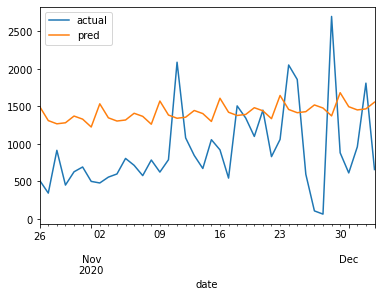

In [67]:
model = Prophet(**best_param).fit(train)
pred = model.predict(model.make_future_dataframe(periods=40))
mape = mean_absolute_error(pred.tail(40).yhat, test.incremental_cases)/mean(test.incremental_cases) 
print(mape)

prediction = pd.DataFrame({'actual':test.incremental_cases.reset_index(drop = True),
              'pred':pred.tail(40).yhat.reset_index(drop = True)})
prediction['date'] = test['date'].reset_index(drop = True)
prediction.plot(x = 'date', y = ['actual', 'pred'])

In [68]:
#PHILLY

In [69]:
philly = data[data['entity'] == 'Pennsylvania-Philadelphia'].loc[:, ['date', 'incremental_cases']]
philly['incremental_cases'] = philly['incremental_cases'].astype('int')
philly['date'] = pd.to_datetime(philly['date'], format="%Y-%m-%d")

# use 85%-15% for train-test split
train = philly.iloc[:230, :].rename(columns = {'date':'ds', 'incremental_cases':'y'})
test = philly.iloc[230:, :]

print(stationary_test(train.y))

(-2.587596964172684, 0.09558791429258168)


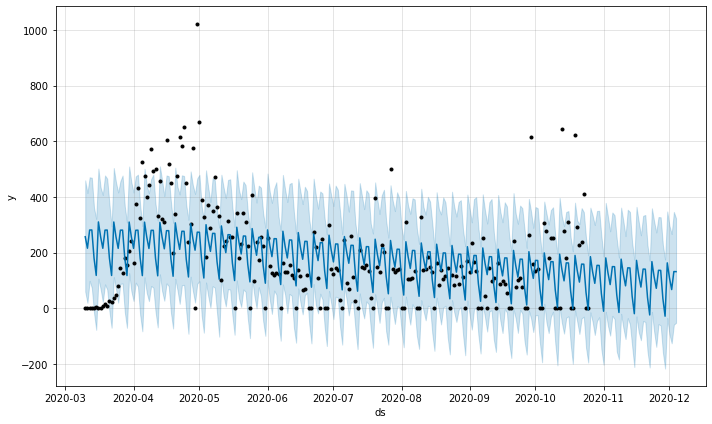

In [70]:
model = Prophet().fit(train)
pred = model.predict(model.make_future_dataframe(periods=40))
model.plot(pred);

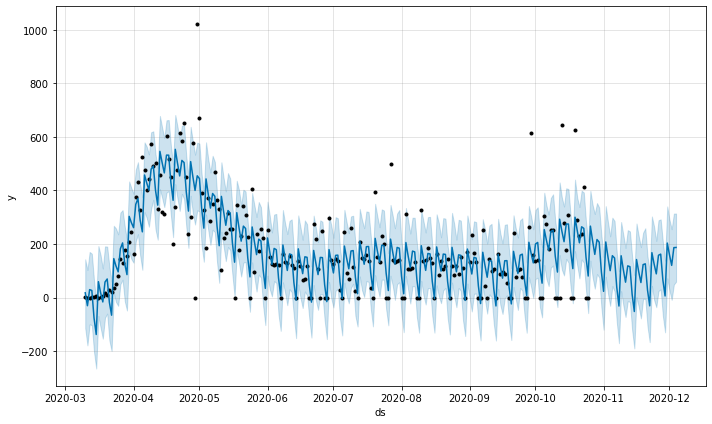

In [71]:
model = Prophet(yearly_seasonality=True, weekly_seasonality=True).fit(train)
pred = model.predict(model.make_future_dataframe(periods=40))
model.plot(pred);

0.8792257168062


<AxesSubplot:xlabel='date'>

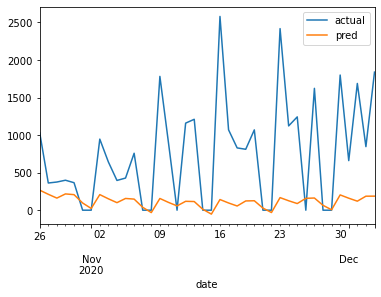

In [72]:
mape = mean_absolute_error(pred.tail(40).yhat, test.incremental_cases)/mean(test.incremental_cases) 
print(mape)
prediction = pd.DataFrame({'actual':test.incremental_cases.reset_index(drop = True),
              'pred':pred.tail(40).yhat.reset_index(drop = True)})
prediction['date'] = test['date'].reset_index(drop = True)
prediction.plot(x = 'date', y = ['actual', 'pred'])

In [73]:
tscv = TimeSeriesSplit(n_splits = 5)

train = train.reset_index().drop(columns = 'index')

param_grid = {
    'changepoint_prior_scale': [0.001, 0.01, 0.1],
    'seasonality_prior_scale': [0.01, 0.1, 1.0],
    'holidays_prior_scale': [0.01, 0.1, 1.0],
    'seasonality_mode': ['additive', 'multiplicative']
}

best_score, best_param = float("inf"), None

for param in ParameterGrid(param_grid):
    all_mse = 0
    for train_index, val_index in tscv.split(train):
      train_data, val_data = train.loc[train_index, :], train.loc[val_index, :]
      model = Prophet(**param).fit(train_data)
      pred = model.predict(val_data)
      mse = mean_squared_error(val_data.y, pred.yhat)
      all_mse = all_mse + mse
    print(f'params: {param} with mean MSE: {all_mse / 3}')
    if all_mse / 3 < best_score:
      best_score, best_param = all_mse / 3, param

print(f'Best Prophet parameters: {best_param} with mean MSE: {best_score}')

Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01} with mean MSE: 172103.49863234835


Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1} with mean MSE: 162162.85082519052


Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0} with mean MSE: 177556.83709301325


Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01} with mean MSE: 171830.70022068382


Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1} with mean MSE: 181732.8289921447


Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0} with mean MSE: 194683.8114319096


Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01} with mean MSE: 172103.49863234835


Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1} with mean MSE: 162162.85082519052


Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0} with mean MSE: 177556.83709301325


Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01} with mean MSE: 171830.70022068382


Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1} with mean MSE: 181732.8289921447


Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0} with mean MSE: 194683.8114319096


Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01} with mean MSE: 172103.49863234835


Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1} with mean MSE: 162162.85082519052


Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0} with mean MSE: 177556.83709301325


Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01} with mean MSE: 171830.70022068382


Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1} with mean MSE: 181732.8289921447


Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0} with mean MSE: 194683.8114319096
params: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01} with mean MSE: 198892.67382307633
params: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1} with mean MSE: 190743.260044746
params: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0} with mean MSE: 189837.51128513252
params: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01} with mean MSE: 194759.15945490205
params: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.

0.8440118336445515


<AxesSubplot:xlabel='date'>

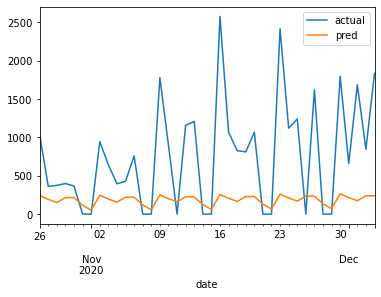

In [74]:
model = Prophet(**best_param).fit(train)
pred = model.predict(model.make_future_dataframe(periods=40))
mape = mean_absolute_error(pred.tail(40).yhat, test.incremental_cases)/mean(test.incremental_cases) 
print(mape)

prediction = pd.DataFrame({'actual':test.incremental_cases.reset_index(drop = True),
              'pred':pred.tail(40).yhat.reset_index(drop = True)})
prediction['date'] = test['date'].reset_index(drop = True)
prediction.plot(x = 'date', y = ['actual', 'pred'])

In [75]:
param_grid = {
    'changepoint_prior_scale': [0.05, 0.075, 0.1, 0.125, 0.15],
    'seasonality_prior_scale': [.2, .5, .7, .9, 1.0],
    'holidays_prior_scale': [0.005,.007, 0.01, 0.015, 0.02],
    'seasonality_mode': ['additive', 'multiplicative']
}

best_score, best_param = float("inf"), None

for param in ParameterGrid(param_grid):
    all_mse = 0
    for train_index, val_index in tscv.split(train):
      train_data, val_data = train.loc[train_index, :], train.loc[val_index, :]
      model = Prophet(**param).fit(train_data)
      pred = model.predict(val_data)
      mse = mean_squared_error(val_data.y, pred.yhat)
      all_mse = all_mse + mse
    print(f'params: {param} with mean MSE: {all_mse / 3}')
    if all_mse / 3 < best_score:
      best_score, best_param = all_mse / 3, param

print(f'Best Prophet parameters: {best_param} with mean MSE: {best_score}')

params: {'changepoint_prior_scale': 0.05, 'holidays_prior_scale': 0.005, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.2} with mean MSE: 195104.4068583935
params: {'changepoint_prior_scale': 0.05, 'holidays_prior_scale': 0.005, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.5} with mean MSE: 157733.703990404
params: {'changepoint_prior_scale': 0.05, 'holidays_prior_scale': 0.005, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.7} with mean MSE: 159641.21988188862
params: {'changepoint_prior_scale': 0.05, 'holidays_prior_scale': 0.005, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.9} with mean MSE: 157473.0436737468
params: {'changepoint_prior_scale': 0.05, 'holidays_prior_scale': 0.005, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0} with mean MSE: 157068.12637399684
params: {'changepoint_prior_scale': 0.05, 'holidays_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.2} with m

params: {'changepoint_prior_scale': 0.05, 'holidays_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.9} with mean MSE: 159535.63199987242
params: {'changepoint_prior_scale': 0.05, 'holidays_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0} with mean MSE: 159811.69923681222
params: {'changepoint_prior_scale': 0.075, 'holidays_prior_scale': 0.005, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.2} with mean MSE: 154642.33318496958
params: {'changepoint_prior_scale': 0.075, 'holidays_prior_scale': 0.005, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.5} with mean MSE: 155136.30423137287
params: {'changepoint_prior_scale': 0.075, 'holidays_prior_scale': 0.005, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.7} with mean MSE: 155368.30011530747
params: {'changepoint_prior_scale': 0.075, 'holidays_prior_scale': 0.005, 'seasonality_mode': 'additive', 'seasonality_prior_scale':

params: {'changepoint_prior_scale': 0.075, 'holidays_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.5} with mean MSE: 159916.77654499927
params: {'changepoint_prior_scale': 0.075, 'holidays_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.7} with mean MSE: 160177.38457355223
params: {'changepoint_prior_scale': 0.075, 'holidays_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.9} with mean MSE: 159589.5972210051
params: {'changepoint_prior_scale': 0.075, 'holidays_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0} with mean MSE: 158733.00944644175
params: {'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.005, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.2} with mean MSE: 155598.32707539728
params: {'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.005, 'seasonality_mode': 'additive', 'seasonality_prior_

params: {'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.02, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0} with mean MSE: 155540.06733996843
params: {'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.2} with mean MSE: 157319.56892321407
params: {'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.5} with mean MSE: 158429.50323580726
params: {'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.7} with mean MSE: 158731.24908006162
params: {'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.9} with mean MSE: 157498.40746097628
params: {'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'seasonality_prior_sca

params: {'changepoint_prior_scale': 0.125, 'holidays_prior_scale': 0.02, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.7} with mean MSE: 151241.44817425788
params: {'changepoint_prior_scale': 0.125, 'holidays_prior_scale': 0.02, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.9} with mean MSE: 153962.0333106893
params: {'changepoint_prior_scale': 0.125, 'holidays_prior_scale': 0.02, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0} with mean MSE: 155242.0464283659
params: {'changepoint_prior_scale': 0.125, 'holidays_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.2} with mean MSE: 152843.09816367985
params: {'changepoint_prior_scale': 0.125, 'holidays_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.5} with mean MSE: 153499.2401125028
params: {'changepoint_prior_scale': 0.125, 'holidays_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale'

params: {'changepoint_prior_scale': 0.15, 'holidays_prior_scale': 0.02, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.2} with mean MSE: 149380.32208803014
params: {'changepoint_prior_scale': 0.15, 'holidays_prior_scale': 0.02, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.5} with mean MSE: 149626.85777195287
params: {'changepoint_prior_scale': 0.15, 'holidays_prior_scale': 0.02, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.7} with mean MSE: 152200.91154444267
params: {'changepoint_prior_scale': 0.15, 'holidays_prior_scale': 0.02, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.9} with mean MSE: 150720.6532327556
params: {'changepoint_prior_scale': 0.15, 'holidays_prior_scale': 0.02, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0} with mean MSE: 151308.84745854532
params: {'changepoint_prior_scale': 0.15, 'holidays_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.2} with mean

0.8076658365263365


<AxesSubplot:xlabel='date'>

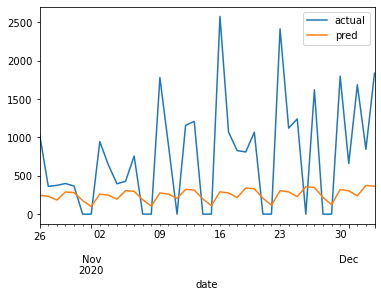

In [76]:
model = Prophet(**best_param).fit(train)
pred = model.predict(model.make_future_dataframe(periods=40))
mape = mean_absolute_error(pred.tail(40).yhat, test.incremental_cases)/mean(test.incremental_cases) 
print(mape)

prediction = pd.DataFrame({'actual':test.incremental_cases.reset_index(drop = True),
              'pred':pred.tail(40).yhat.reset_index(drop = True)})
prediction['date'] = test['date'].reset_index(drop = True)
prediction.plot(x = 'date', y = ['actual', 'pred'])